
# Here I'm process by chunks the entire region.

In [2]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
## Use the ggplot style
plt.style.use('ggplot')

In [3]:
from external_plugins.spystats import tools
%run ../testvariogram.py

/opt/conda/envs/biospytial/lib/python2.7/site-packages/IPython/core/pylabtools.py:168: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  safe_execfile(fname,*where,**kw)


In [4]:
section.shape

(1841, 48)

## Algorithm for processing Chunks
1. Make a partition given the extent
2. Produce a tuple (minx ,maxx,miny,maxy) for each element on the partition
3. Calculate the semivariogram for each chunk and save it in a dataframe
4. Plot Everything
5. Do the same with a mMatern Kernel

In [5]:
minx,maxx,miny,maxy = getExtent(new_data)

In [6]:
maxy

1556957.5046647713

In [7]:
## Let's build the partition
N = 6
xp,dx = np.linspace(minx,maxx,N,retstep=True)
yp,dy = np.linspace(miny,maxy,N,retstep=True)


In [68]:
dx

920016.69306643459

In [9]:
xx,yy = np.meshgrid(xp,yp)

In [10]:
coordinates_list = [ (xx[i][j],yy[i][j]) for i in range(N) for j in range(N)]

In [11]:
from functools import partial
tuples = map(lambda (x,y) : partial(getExtentFromPoint,x,y,step_sizex=dx,step_sizey=dy)(),coordinates_list)

In [12]:
len(tuples)

36

In [13]:
chunks = map(lambda (mx,Mx,my,My) : subselectDataFrameByCoordinates(new_data,'newLon','newLat',mx,Mx,my,My),tuples)
chunks_sizes = map(lambda df : df.shape[0],chunks)

In [14]:
chunk_w_size = zip(chunks,chunks_sizes)

In [15]:
## Here we can filter based on a threshold
threshold = 10
nonempty_chunks_w_size = filter(lambda (df,n) : df.shape[0] > threshold ,chunk_w_size)
chunks_non_empty, chunks_sizes = zip(*nonempty_chunks_w_size)

In [16]:
lengths = pd.Series(map(lambda ch : ch.shape[0],chunks_non_empty))

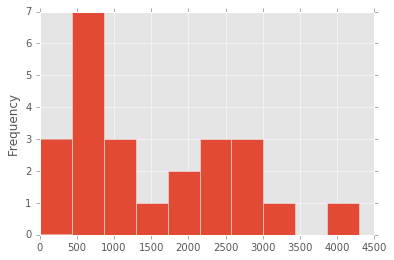

In [17]:
lengths.plot.hist()

In [18]:
cs = chunks_non_empty
variograms =map(lambda chunk : tools.Variogram(chunk,'residuals1',using_distance_threshold=600000),cs)

In [19]:
%time vars = map(lambda v : v.calculateEmpirical(),variograms)
%time vars = map(lambda v : v.calculateEnvelope(num_iterations=1),variograms)

CPU times: user 47.9 s, sys: 5.8 s, total: 53.7 s
Wall time: 53.8 s
CPU times: user 1min 27s, sys: 8.22 s, total: 1min 35s
Wall time: 1min 35s


In [20]:
%time lags = map(lambda v : v.lags,variograms)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 23.1 µs


In [21]:
lags = pd.DataFrame(lags).transpose()

In [22]:
lags = lags[[0]]

## Take an average of the empirical variograms also with the envelope. 
### We will use the group by directive on the field lags


In [23]:
envslow = pd.concat(map(lambda df : df[['envlow']],vars),axis=1)
envhigh = pd.concat(map(lambda df : df[['envhigh']],vars),axis=1)
variogram = pd.concat(map(lambda df : df[['variogram']],vars),axis=1)
n_points = pd.DataFrame(map(lambda v : v.n_points,variograms))

In [24]:
points = n_points.transpose()

In [25]:
print(variogram.shape)
print(points.shape)

(49, 24)
(49, 24)


In [26]:
ejem1 = pd.DataFrame(variogram.values * points.values)

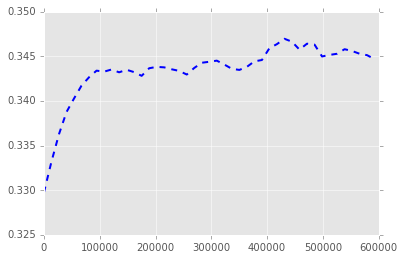

In [27]:
# Chunks (variograms) columns
# lag rows
vempchunk = ejem1.sum(axis=1) / points.sum(axis=1)
plt.plot(lags,vempchunk,'--',color='blue',lw=2.0)

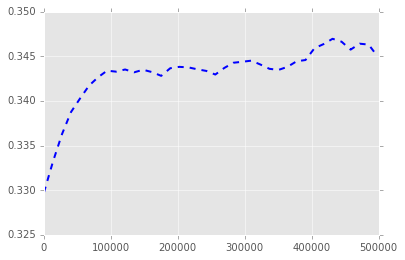

In [28]:
## Cut some values
vchunk = pd.concat([lags,vempchunk],axis=1)
vchunk.columns = ['lags','semivariance']
v = vchunk[vchunk['lags'] < 500000]
plt.plot(v.lags,v.semivariance,'--',color='blue',lw=2.0)
#vemp2



### Let's bring the whole empirical variogram (calculated in HEC) 
For comparison purposes


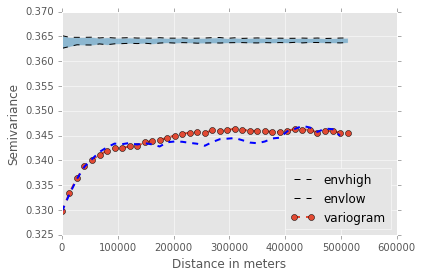

In [78]:
thrs_dist = 1000000
nt = 30 # num iterations
filename = "../HEC_runs/results/low_q/data_envelope.csv"
envelope_data = pd.read_csv(filename)
gvg = tools.Variogram(new_data,'logBiomass',using_distance_threshold=thrs_dist)
gvg.envelope = envelope_data
gvg.empirical = gvg.envelope.variogram
gvg.lags = gvg.envelope.lags
vdata = gvg.envelope.dropna()
gvg.plot(refresh=False,legend=False,percentage_trunked=20)
plt.plot(v.lags,v.semivariance,'--',color='blue',lw=2.0)

## Ok, now the thing that I was supposed to do since the begining
The log of the species instead of only species number


In [30]:
cs = chunks_non_empty
variograms2 =map(lambda chunk : tools.Variogram(chunk,'residuals2',using_distance_threshold=600000),cs)
%time vars = map(lambda v : v.calculateEmpirical(),variograms2)
%time vars = map(lambda v : v.calculateEnvelope(num_iterations=1),variograms2)
%time lags = map(lambda v : v.lags,variograms2)
lags = pd.DataFrame(lags).transpose()
envslow = pd.concat(map(lambda df : df[['envlow']],vars),axis=1)
envhigh = pd.concat(map(lambda df : df[['envhigh']],vars),axis=1)
variogram2 = pd.concat(map(lambda df : df[['variogram']],vars),axis=1)

CPU times: user 48.2 s, sys: 4.46 s, total: 52.6 s
Wall time: 52.6 s
CPU times: user 1min 28s, sys: 8.45 s, total: 1min 37s
Wall time: 1min 37s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 25 µs


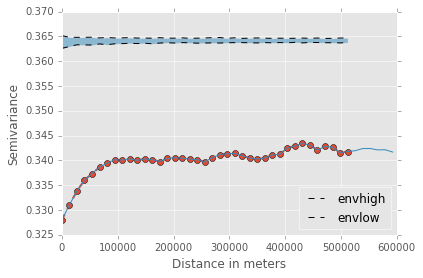

In [83]:

n_points = pd.DataFrame(map(lambda v : v.n_points,variograms2))
points = n_points.transpose()
ejem2 = pd.DataFrame(variogram2.values * points.values)
# Chunks (variograms) columns
# lag rows
vempchunk2 = ejem2.sum(axis=1) / points.sum(axis=1)
#plt.plot(lags,vempchunk2,'--',color='blue',lw=2.0)
thrs_dist = 1000000
nt = 30 # num iterations
filename = "../HEC_runs/results/low_q/data_envelope.csv"
envelope_data = pd.read_csv(filename)
gvg = tools.Variogram(new_data,'logBiomass',using_distance_threshold=thrs_dist)
gvg.envelope = envelope_data
gvg.empirical = vempchunk2
gvg.lags = gvg.envelope.lags
vdata = gvg.envelope.dropna()

gvg.plot(refresh=False,legend=False,percentage_trunked=20)
plt.plot(variograms2[0].lags,vempchunk2)
#plt.plot(v.lags,v.semivariance,'--',color='blue',lw=2.0)

In [92]:
## Save the emp variogram
#variograms2[0].lags
outputvar = pd.DataFrame([variograms2[0].lags,vempchunk2]).transpose()
outputvar.columns = ['lags','semivariance']
outputvar.to_csv("/outputs/logbiomas_logsppn_residuals_variogram.csv")


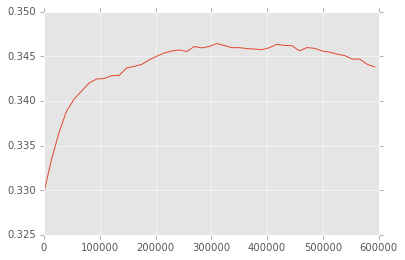

In [60]:
## Here I´ll plot the thing
plt.plot(vdata.lags,vdata.variogram)


## The variograms for logbiomas and log sppn are different from logbiomass and log sppn. 
Being the logSppn lower spatial variance. Indeed the sill reaches lower variance. 

The chunk method provides a faster way of calculating the empirical variogram albeit a slightly more uncertainty (noise)
when compared with the global variogram.

### To do now.

1 .Revisit the model for generating the covariance matrix
2. The problem was that the matrix was not positive semidefinite. There could be repetitions in the original data


In [61]:
## test duplicates in new_data
new_data[new_data.duplicated(['newLon'], keep=False)]

,Unnamed: 0,STATECD,STATENM,STATEAB,COUNTYCD,PLOT,PLOT_ID,PlotIDn,LAT,LON,...,AET,lon,lat,geometry,logBiomass,newLon,newLat,logSppN,residuals1,residuals2


In [62]:
## Remove duplications
withoutrep = new_data.drop_duplicates(subset=['newLon','newLat'])
print(new_data).shape
print(withoutrep).shape
new_data = withoutrep


(36844, 48)
(36844, 48)


In [63]:
def gaussianVariogram(h,sill=0,range_a=0,nugget=0):
    if isinstance(h,np.ndarray):
        Ih = np.array([1.0 if hx >= 0.0 else 0.0 for hx in h])
    else:
        Ih = 1.0 if h >= 0 else 0.0
    #Ih = 1.0 if h >= 0 else 0.0    
    g_h = ((sill - nugget)*(1 - np.exp(-(h**2 / range_a**2)))) + nugget*Ih
    return g_h
## Fitting model.
### Optimizing the empirical values
def theoreticalVariogram(model_function,sill,range_a,nugget):
    return lambda x : model_function(x,sill,range_a,nugget)

In [64]:
dt = pd.concat([lags[[0]],vempchunk2],axis=1)
dt.columns = ['lags','semivariance']
vdata = dt.dropna()

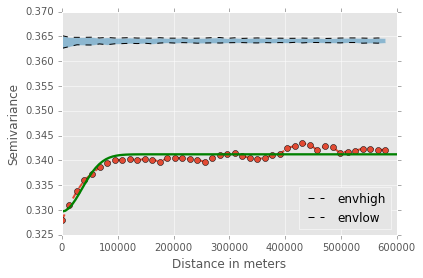

In [76]:
import matplotlib.pylab as plt
hx = np.linspace(0,600000,100)
from scipy.optimize import curve_fit
s = 0.345
r = 100000.0
nugget = 0.33
init_vals = [0.34, 50000, 0.33]     # for [amp, cen, wid]
bg, covar_gaussian = curve_fit(gaussianVariogram, xdata=vdata.lags.values, ydata=vdata.semivariance.values, p0=init_vals)
#vdata = gvg.envelope.dropna()
## The best parameters asre:
gau_var = gaussianVariogram(hx,bg[0],bg[1],bg[2])
## The best is the gaussian
#model_var = theoreticalVariogram(gaussianVariogram,bg[0],bg[1],bg[2])

#gvg.empirical = vdata.
#empirical variogram logbiomas ~ sppn
gvg.plot(refresh=False,legend=False)

#empirical variogram by chunks logbiomass ~ logsppn 
#plt.plot(dt.lags,dt.semivariance,'--',color='blue',lw=2.0)
#model
plt.plot(hx,gau_var,color='green',lw=2.3)
#plt.plot(hx,exp_var)


## The best fitted parameters are:
Sill, range , nugget (respectively)



In [39]:
print("Sill %s, Range %s, Nugget %s"%(bg[0],bg[1],bg[2]))

Sill 0.34122564947, Range 50318.763452, Nugget 0.329687351696



## Now for finishing I need to perform the lucky step,
Re fit the $\beta$ 

Oke, first calculate the distances


In [1]:
import statsmodels.regression.linear_model as lm
%time Mdist = gvg.distance_coordinates.flatten()
#%time vars = np.array(map(model_var,Mdist))
#CovMat = vars.reshape(len(section),len(section))
#X = section.logSppN.values
#Y = section.logBiomass.values

NameError: name 'gvg' is not defined

In [ ]:
# But the data is massive and it consumes all my RAM (32 GB) I need to  do something clever.
covar = []
for i in range(len(Mdist)):
    x = Mdist.pop(i)
    g = gaussianVariogram(x,bg[0],bg[1],bg[2])
    covar.append(g)

In [138]:
### Apply the distance function, rememeber that now it receives a list (array) as X
%time vars = gaussianVariogram(Mdist,bg[0],bg[1],bg[2])

MemoryError: 

In [72]:
values = lags[[0]].values

In [74]:
for i in range(len(values)):
    print(values[i] - values[i+1])

[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]
[-13469.3877551]


IndexError: index 49 is out of bounds for axis 0 with size 49